In [1]:
#nom tout en minuscule 
#hadrami soukeina 

# TP 3 : classification de documents

(inspiré pour partie d'un TP par Antoine Simoulin)

La **classification de textes** est la tâche qui prend en entrée du texte, et prédit en sortie une ou plusieurs classes pour ce texte, l'important étant que l'ensemble des classes possibles est connu et fixé a priori.

## Exemples de tâches relevant de la "classification de texte"

De nombreuses applications de TAL correspondent à de la classification de textes. Par exemple :
* L'"**analyse de sentiments**" (ou "sentiment analysis"): est un nom pompeux pour la tâche d'identification de  la polarité positive ou négative d'un texte, appliqué par exemple pour déterminer
  * ce client est-il content ou pas?
  * ce spectateur a-t-il aimé ce film ou pas?
  * ...
* La détection de Spam dans les Emails
* Le suivi de tendances sur les réseaux sociaux
* Recherche de réponse dans une FAQ...


## Les données 

On utilise les données de classification de textes pour le français, telles qu'inclusent dans les données FLUE <a href="https://aclanthology.org/2020.lrec-1.302/">(Le et al., 2020)</a>, cf. le repo https://github.com/getalp/Flaubert/tree/master/flue.

Nous utilisons ici un extrait de la partie française d'un corpus d'"analyse de sentiment" multilingue, le corpus CLS <a href="https://aclanthology.org/P10-1114/">(Prettenhofer and Stein, 2010)</a>.

Les textes sont des revues par des utilisateurs, issues du site Amazon pour trois catégories de produits (livres, DVD et musique). Initialement, chaque exemple contenait une revue associée à une note allant de 1 à 5, mais les revues avec une note de 3 ont été écartées, et les notes ont été binarisées: 1/2 devient 0 ("négatif"), et 4/5 devient 1 ("positif"). 

Pour chaque catégorie de produit (livres, dvd, musique), les données cls-fr de FLUE contiennent 2000 revues de test, et 2000 revues d'apprentissage. Pour ce TP, nous avons en outre divisé les 2000 revues d'apprentissage en 1600 pour l'entraînement, et 400 pour la validation.



### Import des librairies

In [2]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
%%capture

# ⚠️ Execute only if running in Colab
if 'google.colab' in str(get_ipython()):
  IN_COLAB = True
else:
  IN_COLAB = False

if IN_COLAB:
  !pip install -q scikit-learn==0.23.2 matplotlib==3.3.2 pandas==1.1.3 nltk==3.5 spacy==2.3.2 
  !python3 -m spacy download fr_core_news_md
  # if running Colab, restart after libraries installation (Redémarrer l'environnement d'exécution)
  # exit()

In [4]:
import os, sys
import numpy as np  # python base math library
import pandas as pd # data structure

from collections import Counter
#from pprint import pprint
#from time import time
import logging
import itertools
import matplotlib.pyplot as plt

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')

# IPython automatically reload all changed code
%load_ext autoreload
%autoreload 2

# Inline Figures with matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
def load_cls_file(file_path):
    reviews, labels = [], []
    with open(file_path) as f:
        line = f.readline()
        while line:
            review, label = line.strip().split('\t')
            reviews.append(review.strip("\""))
            labels.append(int(label))
            line = f.readline()
    return reviews, labels

def load_cls_dataset(file_path, section='books'):
    part2X, part2y = {}, {}
    for part in ['train', 'valid']:  
        part2X[part], part2y[part] = load_cls_file(os.path.join(file_path, section, part+'_0.tsv'))
    return part2X, part2y

## Chargement des données

In [6]:
data_dir = './data_flue_cls_fr/'

In [7]:
X = {} # key1=cat, key2=part, val= list of reviews
y = {} # key1=cat, key2=part, val= list of labels
y_train = [] # les labels "gold" pour la partie train
y_valid = [] # les labels "gold" pour la partie validation
for genre in ['books', 'dvd', 'music']:
    X[genre], y[genre] = load_cls_dataset(data_dir, genre)
    y_train += y[genre]['train']
    y_valid += y[genre]['valid']

In [8]:
df = {} # key=cat, val = data frame
for part in ['train', 'valid']:
    df[part] = pd.DataFrame.from_dict(
    {'review': X['books'][part] + X['dvd'][part] + X['music'][part],
     'label': y['books'][part] + y['dvd'][part] + y['music'][part],
     'genre': ['books' for _ in range(len(X['books'][part]))] \
             + ['dvd' for _ in range(len(X['dvd'][part]))] \
             + ['music' for _ in range(len(X['music'][part]))]})

id2label = ['Négatif', 'Positif']

In [9]:
pd.options.display.max_colwidth = 300
df['train'].head(10)

review  \
0  Je voulais mettre 0 étoile mais c'est pas possible... Commençons par le positif (c'est rapide): ça parle de tout : muxle, endurance, souplesse, alimentation, échauffement mais ... mal, désespérement mal. L'auteur prétend avoir fait 15 ans de recherche avant de pondre son opus majus. Ben faudrait...   
1  Le récit de vie d'une femme américaine, avec ses contradictions, ses rêves de liberté, de justice (dans l'amérique de la guerre du Vietnam). Un récit qui n'est pas prêt de me quitter sur la complexité de la nature humaine dans ce qu'elle a de plus tortueux et de plus insaisissable. Un récit cons...   
2  Quel chef d'oeuvre que cette 'autobiographie' ! C'est à croire que la vie de Michaël Crichton est aussi palpitante, voire plus par moments, que celle des personnages de ses romans... Que d'aventures, de découvertes, d'expérience ! On comprend mieux, après la lecture de cet ouvrage, d'où lui vien...   
3  Si vous cherchez un livre simple d'initiation à Scheme pour comprendre et modifier les Script-Fu de Gimp, ne faites pas comme moi, choisissez-en un autre. Si vous voulez étudier ce langage d'un point de vue théorique, sans allumer votre ordinateur, en entrant dans le détail des algorithmes, sans...   
4  Ce livre est très intéressant à lire à plus d'un titre. Certes JF Revel voit juste dans son analyse au sujet de la pensée ambiante vis-à-vis des USA. Cependant il manque totalement de rigueur scientifique (beaucoup d'assertions sans références bibliographiques). Cet ouvrage bien qu'éclairant ne ...   
5  J'avais déjà été déçue par ""Dossier Benton"". Mais là, que dire de ""L'Ile des Chiens"" ??? Quel ennui ! Les personnages sont burlesques, et l'intrigue initéressante ! Je suis pourtant une inconditionnelle de celle que je considérais comme LA reine du thriller. On ne ressuscitera pas Benton, ma...   
6  Michel Hoàng trace un portrait captivant du plus grand conquérant de l'histoire. Il dépeint les mœurs de ces nomades de la steppe qui engendreront Tèmudjin, le fils de petit chef qui s'élèvera au range de Khan océanique. L'ascension lente et patiente faite à coup d'alliances et « desalliance » d...   
7                                                                    Que lui avons-nous fait? Pourquoi la belle Amélie se croit-elle obligée de nous décevoir chaque année? Si le but est de nous prouver que le génie ne s'utilise pas comme une clé de 12, la démonstration en a été faite depuis longtemps.   
8  Il y a deux manières d'envisager ce livre. Sur le plan de la méthode, Encel expose le Golan d'un point de vue géopolitique, ce qui peut être pertinent... jusqu'à un certain point. En effet, au-delà de certaines imprécisions, voire confusions dans la réalité historique du Golan, l'auteur en vient...   
9  On s'attend avec ce livre à découvrir un pays, une époque, et surtout lire un roman d'espionnage, quelque chose de palpitant, qui s'emballe, un livre que l'on ne peut plus quitter quand on l'a ouvert. Malheureusement, le scénario s'essouffle au fil des pages, pour devenir carrément asthmatique à...   

   label  genre  
0      0  books  
1      1  books  
2      1  books  
3      1  books  
4      0  books  
5      0  books  
6      1  books  
7      0  books  
8      0  books  
9      0  books

## Exploration des données

Avant de commencer à dérouler un cas d'usage, vous devez toujours **analyser les données**. Vérifiez les valeurs manquantes ou abérrantes, la distribution des variables, l'équilibre des classes, sélectionnez ou écartez les variables en fonction de leur pertinence ou selon des critères éthiques.

### TODO1: Comparer la distribution des labels positifs / négatifs, et des genres (music, dvd, books)

In [10]:
print("nombre de valeur null dans le dataframe train")
print(df["train"].isnull().sum())
print("nombre de valeur null dans le dataframe valid")
print(df["valid"].isnull().sum())

nombre de valeur null dans le dataframe train
review    0
label     0
genre     0
dtype: int64
nombre de valeur null dans le dataframe valid
review    0
label     0
genre     0
dtype: int64


In [11]:
print("On a deux label 0 et 1, la distribution de ces labels est presque uniforme sur les labels avec un label positif de plus que négatif")
df["train"].groupby("label").count()

On a deux label 0 et 1, la distribution de ces labels est presque uniforme sur les labels avec un label positif de plus que négatif


review  genre
label               
0        2400   2400
1        2399   2399

In [12]:
print("La distibution par rapport au genre est également uniforme ")
df["train"].groupby("genre").count()

La distibution par rapport au genre est également uniforme 


review  label
genre               
books    1600   1600
dvd      1600   1600
music    1599   1599

In [13]:
print("De même la distibution par rapport au genre et au label ")
df["train"].groupby(['label','genre']).count()


De même la distibution par rapport au genre et au label 


review
label genre        
0     books     800
      dvd       800
      music     800
1     books     800
      dvd       800
      music     799

In [14]:
print( "Égalemnt pour le dataframe valid tout est répartie équitablement entre les différents genre et/ou label")

Égalemnt pour le dataframe valid tout est répartie équitablement entre les différents genre et/ou label


In [15]:
df["valid"].groupby("genre").count()

review  label
genre               
books     400    400
dvd       399    399
music     399    399

In [16]:
df["valid"].groupby("label").count()

review  genre
label               
0         600    600
1         598    598

In [17]:
df["valid"].groupby(['label','genre']).count()

review
label genre        
0     books     200
      dvd       200
      music     200
1     books     200
      dvd       199
      music     199

## Pré-traitements des textes: tokenisation, lemmatisation, stemming

### TODO2 : normalisation du vocabulaire

- tokenisez et lemmatisez les revues en utilisant Spacy (cf. TP2)
  * NB: dans le pipeline spacy, ci-dessous, on ne conserve que les modules nécessaires à la lemmatisation
- utilisez la racinisation ("stemming") implémenté dans NLTK
- vous **stockerez** ces informations dans la DataFrame, pour chaque revue, les champs "tokens", "lemmas" et "stems"

- **comparez** les tailles de vocabulaire, pour les revues du "train", pour les 3 types de tokens
  -- les tokens obtenus après tokenization spacy
  -- les lemmes obtenus après lemmatisation spacy
  -- les stems obtenus après "racinisation" (en anglais "stemming") NLTK

In [18]:
import spacy

try:
    #rem: enable does not seem to work, don't know why
    nlp = spacy.load("fr_core_news_md") #, enable=["tok2vec", "morphologizer", "lemmatizer"])
except OSError:
    !python -m spacy download fr_core_news_md
    nlp = spacy.load("fr_core_news_md") #, enable=["tok2vec", "morphologizer", "lemmatizer"])

# we won't need ner, parser, attribute_ruler
# NB: tok2vec and morphologizer seem to be necessary for lemmatization
nlp.remove_pipe("ner")
nlp.remove_pipe("parser")
nlp.remove_pipe("attribute_ruler")
print('Current pipeline:\n  '+'\n  '.join(nlp.pipe_names))



Current pipeline:
  tok2vec
  morphologizer
  lemmatizer


In [19]:
# remarque: le type de lemmatiseur Spacy, pour le modèle fr_core_news_md est "rule" = "par règles"
for c in nlp.components:
    print(c)
    if c[0] == 'lemmatizer':
        print(c[1].mode)

('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x7f8f1906ebe0>)
('morphologizer', <spacy.pipeline.morphologizer.Morphologizer object at 0x7f8f1906ec40>)
('senter', <spacy.pipeline.senter.SentenceRecognizer object at 0x7f8f1906e8e0>)
('lemmatizer', <spacy.lang.fr.lemmatizer.FrenchLemmatizer object at 0x7f8f18ac1640>)
rule


In [20]:
def tok(doc): 
    tokens = [token.text for token in doc]
    return tokens

def lemx(doc): 
    lems = [token.lemma_ for token in doc]
    return lems

def stemsx(doc): 
    lems = [stemmer.stem(token) for token in doc]
    return lems

In [21]:
sample_text = """Je voulais mettre 0 étoile mais c'est pas possible...
 Commençons par le positif (c'est rapide): ça parle de tout : 
muxle, endurance, souplesse, alimentation, échauffement mais ... mal, désespérement mal."""

# testez la tokenization / lemmatisation sur le texte supra
# puis appliquez à l'ensemble des revues

sample_nlp=nlp(sample_text)
print("tokenisation de sample_text: \n",tok(sample_nlp))
print("lemmatisation de sample_text: \n",lemx(sample_nlp))

tokenisation de sample_text: 
 ['Je', 'voulais', 'mettre', '0', 'étoile', 'mais', "c'", 'est', 'pas', 'possible', '...', '\n ', 'Commençons', 'par', 'le', 'positif', '(', "c'", 'est', 'rapide', '):', 'ça', 'parle', 'de', 'tout', ':', '\n', 'muxle', ',', 'endurance', ',', 'souplesse', ',', 'alimentation', ',', 'échauffement', 'mais', '...', 'mal', ',', 'désespérement', 'mal', '.']
lemmatisation de sample_text: 
 ['je', 'vouloir', 'mettre', '0', 'étoile', 'mais', 'ce', 'être', 'pas', 'possible', '...', '\n ', 'commençon', 'par', 'le', 'positif', '(', 'ce', 'être', 'rapide', '):', 'cela', 'parle', 'de', 'tout', ':', '\n', 'muxle', ',', 'endurance', ',', 'souplesse', ',', 'alimentation', ',', 'échauffement', 'mais', '...', 'mal', ',', 'désespérement', 'mal', '.']


In [22]:
# le stemmer de NLTK
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

print(stemmer.stem("déménagement"))
print(stemmer.stem("remplissons"))

déménag
rempl


In [23]:
%%time
# application aux revues de la lemmatisation Spacy et la racinisation NLTK
# NB: il est important de n'appeler qu'une seule fois le traitement spacy sur un texte
#     cf. coûteux en temps

#création d'une colone nlp_element pour ne pas appeler la fonction nlp 
#plusieurs fois

df['train']['nlp_element'] = df['train']['review'].apply(lambda x: nlp(x))
df['valid']['nlp_element'] = df['valid']['review'].apply(lambda x: nlp(x))



CPU times: user 59.5 s, sys: 600 ms, total: 1min
Wall time: 1min


In [24]:
df['train']['tokens'] = df['train']['nlp_element'].apply(lambda x: tok(x))
df['train']['lemmas'] = df['train']['nlp_element'].apply(lambda x: lemx(x))
df['train']['stems'] = df['train']['tokens'].apply(lambda x: stemsx(x))

df['train']

review  \
0     Je voulais mettre 0 étoile mais c'est pas possible... Commençons par le positif (c'est rapide): ça parle de tout : muxle, endurance, souplesse, alimentation, échauffement mais ... mal, désespérement mal. L'auteur prétend avoir fait 15 ans de recherche avant de pondre son opus majus. Ben faudrait...   
1     Le récit de vie d'une femme américaine, avec ses contradictions, ses rêves de liberté, de justice (dans l'amérique de la guerre du Vietnam). Un récit qui n'est pas prêt de me quitter sur la complexité de la nature humaine dans ce qu'elle a de plus tortueux et de plus insaisissable. Un récit cons...   
2     Quel chef d'oeuvre que cette 'autobiographie' ! C'est à croire que la vie de Michaël Crichton est aussi palpitante, voire plus par moments, que celle des personnages de ses romans... Que d'aventures, de découvertes, d'expérience ! On comprend mieux, après la lecture de cet ouvrage, d'où lui vien...   
3     Si vous cherchez un livre simple d'initiation à Scheme pour comprendre et modifier les Script-Fu de Gimp, ne faites pas comme moi, choisissez-en un autre. Si vous voulez étudier ce langage d'un point de vue théorique, sans allumer votre ordinateur, en entrant dans le détail des algorithmes, sans...   
4     Ce livre est très intéressant à lire à plus d'un titre. Certes JF Revel voit juste dans son analyse au sujet de la pensée ambiante vis-à-vis des USA. Cependant il manque totalement de rigueur scientifique (beaucoup d'assertions sans références bibliographiques). Cet ouvrage bien qu'éclairant ne ...   
...                                                                                                                                                                                                                                                                                                           ...   
4794  limp bizkit est au metal ce que britney spears est a la musique!!! C'est a dire honteux et commercial!!! Cet album surf sur une mode lancee par korn et n'ajoute rien au genre!!! Les musiciens n'ont aucun talent , surtout wes borland (guitare) qui n'a aucun son et plagie la plupart de ses riffs (...   
4795  Je ne donne ici que mon avis personnel. Pour moi cet album est lamentable. Ce n'est plus le meme groupe. Kirk Hammet a perdu ses competences de guitaristes (pas un seul solo ...), la batterie est pourrie et couvre tout, la production pitoyable (enregistré dans des toilettes ?). Les chansons sont...   
4796  On tient sans doute dans ce disque l'opus le plus abouti et le plus cohérent de la seconde partie de la carrière du poète canadien. Trouvant son unité dans l'usage systématique de nappes de synthétiseurs et de choeurs féminins se mariant harmonieusement à la voix grave du chanteur, l'album alter...   
4797  4° album et pas une ride: LE death metal des initiés. On pourrait même dire que cet album va plus loin que ""Failure for gods"" non seulement du fait du son énorme, mais surtout de compo monstrueuses où la puissance du groupe se mêle à une complexité délirante mais jamais indigeste. Le plus fort...   
4798                                                    pas de polémique: les dream theater sont très très bon techniquement, y'a pas à redire. mais question composition, ils ont toujours été pompeux et à la limite du chiant. maintenant ils donnent dans l'insipide après le plagiat. bientôt l'autoparodie?   

      label  genre  \
0         0  books   
1         1  books   
2         1  books   
3         1  books   
4         0  books   
...     ...    ...   
4794      0  music   
4795      0  music   
4796      1  music   
4797      1  music   
4798      0  music   

                                                                                                                                                                                                                                                                                                      nlp_element  \
0     (Je, voula

In [25]:
df['valid']['tokens'] = df['valid']['nlp_element'].apply(lambda x: tok(x))
df['valid']['lemmas'] = df['valid']['nlp_element'].apply(lambda x: lemx(x))
df['valid']['stems'] = df['valid']['tokens'].apply(lambda x: stemsx(x))

df['valid']

review  \
0     Sur ce coup là Michael Crichton est passé complètement à coté d la plaque. Tout d'abord, sachez-le, le mot ""roman"" sur la couverture est seulement un pretexte. Car ce n'en est pas un. Pas de réelle intrigue, personnages completements transparents et stéréotypés, deux rebondissements en tout da...   
1                                                                                                                                                                                             Le premier de la série part sur de bonnes bases mais après scénario sans grandes surprises,...Pas extraordinaire...   
2                                                                                                    Autant la quatrième de couverture laisse espérer de bons moments de lecture, autant le livre est décevant ! les personnages ne sont pas attachants, l'histoire manque de piment et la fin est sans surprise.   
3                                                Je suis très déçue par ce livre, on m'en avait dit tellement du bien, et moi, franchement, je n'ai pas aimé du tout... Trop de froideur, peu d'intérêt à l'histoire, et des sentiments glaciaux. Bref, j'ai fini en survolant les pages, aucun intérêt pour moi.   
4     On aurait pu s'attendre à de la propagande: c'est tout le contraire. Vassili Grossman fait une description pointilleuse de la vie dans les régiments soviétiques, depuis le début de la guerre et la débâcle jusqu'aux marches du Reichstag. Les commentaires d'Antony Beevor sont justes et permettent ...   
...                                                                                                                                                                                                                                                                                                           ...   
1193  Fan des Minds depuis le début ou presque, je suis très déçu par la tournure qu'a pris leur carrière après Street Fighting Years. Déçu par le départ de Mike Mac Neil, par la baisse des ventes et de l'exposition du groupe... J'ai l'impression que l'album Our Songs Remain The Same aurait pu inverse...   
1194  PAUVRE MR JOHNSON ! CLAPTON LUI REND UN BIEN MEDIOCRE HOMMAGE. L'AUDITEUR EST ASSOURDI PAR LA BASSE ET ECRASE PAR LA BATTERIE. RIEN A VOIR AVEC LA LEGERETE ET LE DEPOUILLEMENT DES CHANSONS ENREGISTREES PAR ROBERT JOHNSON. POUR RETROUVER CET ESPRIT, IL VAUT MIEUX SE TOURNER VERS PETER GREEN QUI A...   
1195  Je trouve moi aussi que le ""Green Album"" n'a pas de quoi fouetter un chat, ok ""Hash Pipe"" et ""Island In The Sun"" sont 2 singles sympas mais loins derrière les très bons ""Buddy Holly"" ou ""Say It Ain't So"" (pour ne citer qu'eux) du premier album ! Pinkerton m'avait déjà un peu déçu mais ...   
1196                                                                                                           Voyez en cet album un incontournable du rap US. Ses qualités ? Des productions subtiles de RZA auxquelles se superposent les touches personnelles de chaque rappeur, le résultat est exceptionnel.   
1197                                                                                                                                                                                                                                          Il ne s'agit pas de l'édition limitée avec livret de 94 pages [...]   

      label  genre  \
0         0  books   
1         0  books   
2         0  books   
3         0  books   
4         1  books   
...     ...    ...   
1193      0  music   
1194      0  music   
1195      0  music   
1196      1  music   
1197      0  music   

                                                                                                                                                                                                                                                                                                      nlp_element  \
0     (Sur, ce, 

In [26]:
#comparez les tailles de vocabulaire:

In [27]:
def comp(column_name):
    listtoken= list(np.concatenate(df['train'][column_name].values))
    settoken = set(listtoken)
    len_voc = len(settoken)
    return len_voc

In [28]:
print("la taille du vocabulaire tokenizer est de: ", comp("tokens"))
print("la taille du vocabulaire lemmatiser est de: ", comp("lemmas"))
print("la taille du vocabulaire stemmatiser est de: ", comp("stems"))

la taille du vocabulaire tokenizer est de:  44167
la taille du vocabulaire lemmatiser est de:  32906
la taille du vocabulaire stemmatiser est de:  24532


## Représentation vectorielle de chaque revue: encodage "bag-of-word" (BOW) 

On va chercher à encoder les données comme discuté pendant le premier cours. Le texte va être "vectorisé" afin de pouvoir être traité par des algorithmes. 

**Bag of Words** : C'est la représentation la plus simple. On attribue index à chacun des mots apparaissant dans le corpus d'entrainement. On peut ensuite représenter chaque document par un vecteur X indiquant la présence ou l'absence de chaque mot 'w' dans le dictionnaire. La taille du vocabulaire est généralement comprise entre 50.000 et 100.000 mots.

De plus la majorité des valeurs de X sont nulles puisque pour un document donné, seul quelques centaines de mots sont utilisés. Ainsi, le bag of words est une représentation <i>sparse</i> de <i>grande dimension</i>.

In [29]:
# On considère ce corpus "jouet", constitué de 3 documents déjà tokenisés,
# i.e. chaque document est une liste de formes.

train_corpus = [
    ["je", "n'", "aime", "pas", "ce", "livre"],
    ["un", "livre", "très", "complet", ",", "un", "livre", "magique"],
    ["pas", "un", "livre", "exceptionnel", ",", "ni", "un", "livre", "très", "complet"]]

test_corpus = [
    ["un", "nouveau", "livre", "super"],
    ["et", "un", "autre", "livre", "magique"]
]

### TODO3: représentation BOW d'après un vocabulaire

La première chose à faire est d'associer chaque mot du vocabulaire à un identifiant entier. On part en général de 0. L'ordre n'a pas d'importance.

En général, le vocabulaire est défini comme tous les mots rencontrés dans un certain ensemble de documents (en général, l'ensemble d'apprentissage, train)).

* écrire une fonction **get_vocab** qui parcourt un ens. de documents tokenises (une liste de liste de tokens) et en ressort
  * un dictionnaire **w2id** : clé = mot, valeur = id du mot
    * pour aller des mots vers leur id
  * une liste **id2w**, où au rang i dans la liste, se trouve le mot d'identifiant i
    * pour récupérer d'un id vers le mot auquel il correspond
* écrire une fonction bow qui rend le vecteur bow d'un document (sous forme de liste, où le rang correspond à l'id d'un mot du vocabulaire)
* appliquez vos fonctions pour afficher les vecteurs BOW obtenus pour le mini corpus train_corpus et test_corpus
  * NB: le vocabulaire utilisé est celui du train_corpus
  * les mots présents dans le test mais absents du test_corpus (les "inconnus") seront ici simplement ignorés
    
  


In [30]:
#documents liste de liste de tokens 

def get_vocab(documents):
    
    w2id = {}
    id2w = []
    # TODO
    m=0
    for i in range (0,len(documents)): 
        for j in range (0,len(documents[i])):
            if (documents[i][j] not in w2id):
                id2w.append(documents[i][j])
                w2id[documents[i][j]] = m
                m+=1
                #print(m)

    
    return (w2id, id2w)

def bow(doc, w2id, id2w):
    # TODO
    bow_vector=[0]*len(id2w)
    for i in range(0, len(doc)): 
        if (doc[i] in w2id):
            bow_vector[w2id[doc[i]]]+=1 
    return bow_vector
    

w2id,id2w=get_vocab(train_corpus)

print("w2id : \n" ,w2id,"\n", "\nid2w : \n", id2w,"\n")
print("BOW vectors of train_corpus")

print( "bow_train1: ", bow(train_corpus[0],w2id,id2w))
print( "bow_train2: " , bow(train_corpus[1],w2id,id2w))
print( "bow_train3: ", bow(train_corpus[2],w2id,id2w) )


print("\n")

print("BOW vectors of test_corpus (unknown words are ignored)")
print ("bow_test1", bow(test_corpus[0],w2id,id2w))
print("bow_test2", bow(test_corpus[1],w2id,id2w))

w2id : 
 {'je': 0, "n'": 1, 'aime': 2, 'pas': 3, 'ce': 4, 'livre': 5, 'un': 6, 'très': 7, 'complet': 8, ',': 9, 'magique': 10, 'exceptionnel': 11, 'ni': 12} 
 
id2w : 
 ['je', "n'", 'aime', 'pas', 'ce', 'livre', 'un', 'très', 'complet', ',', 'magique', 'exceptionnel', 'ni'] 

BOW vectors of train_corpus
bow_train1:  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
bow_train2:  [0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 1, 0, 0]
bow_train3:  [0, 0, 0, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1]


BOW vectors of test_corpus (unknown words are ignored)
bow_test1 [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
bow_test2 [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]


In [31]:
# On peut utiliser la librairie sklearn pour comparer.
from sklearn.feature_extraction.text import CountVectorizer

def dummy(document):
    return document


# CountVectorizer is for plain BOW
# we will use it taking as input already pre-processed text, hence
# tokenizer=dummy, preprocessor=dummy
vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy)

# the vectorizer is empty : this generates an error
#print(vectorizer.vocabulary_)
#print(vectorizer.get_feature_names())

# fit_transform will create the vocabulary and correspondences with ids
# AND will produce the BOW vectors for all the documents 
# and transform the training set into a matrix
X_train = vectorizer.fit_transform(train_corpus)


# more precisely, it outputs a matrix (nb rows = nb documents, nb columns = size of vocab)
print("type of X_train", type(X_train))
print("shape of X_train", X_train.shape)
print(X_train)

# here it is as a standard matrix
print(X_train.toarray()) 



type of X_train <class 'scipy.sparse.csr.csr_matrix'>
shape of X_train (3, 13)
  (0, 5)	1
  (0, 8)	1
  (0, 1)	1
  (0, 10)	1
  (0, 2)	1
  (0, 6)	1
  (1, 6)	2
  (1, 12)	2
  (1, 11)	1
  (1, 3)	1
  (1, 0)	1
  (1, 7)	1
  (2, 10)	1
  (2, 6)	2
  (2, 12)	2
  (2, 11)	1
  (2, 3)	1
  (2, 0)	1
  (2, 4)	1
  (2, 9)	1
[[0 1 1 0 0 1 1 0 1 0 1 0 0]
 [1 0 0 1 0 0 2 1 0 0 0 1 2]
 [1 0 0 1 1 0 2 0 0 1 1 1 2]]


In [32]:
# here is the mapping between word forms and ids (our "w2id" above)
print(vectorizer.vocabulary_)
# the list of word forms (our id2w)
print(vectorizer.get_feature_names_out())

{'je': 5, "n'": 8, 'aime': 1, 'pas': 10, 'ce': 2, 'livre': 6, 'un': 12, 'très': 11, 'complet': 3, ',': 0, 'magique': 7, 'exceptionnel': 4, 'ni': 9}
[',' 'aime' 'ce' 'complet' 'exceptionnel' 'je' 'livre' 'magique' "n'" 'ni'
 'pas' 'très' 'un']


In [33]:
# for the test documents: we ignore the new words (unknown in train)
# => use the "transform" method instead of fit_transform

X_test = vectorizer.transform(test_corpus)
print("shape of X_test", X_test.shape)

# What happened to the words in test_corpus that are not present in train_corpus?
# => we can see that the vocab size did not change
print(vectorizer.vocabulary_)
print(vectorizer.get_feature_names_out())



shape of X_test (2, 13)
{'je': 5, "n'": 8, 'aime': 1, 'pas': 10, 'ce': 2, 'livre': 6, 'un': 12, 'très': 11, 'complet': 3, ',': 0, 'magique': 7, 'exceptionnel': 4, 'ni': 9}
[',' 'aime' 'ce' 'complet' 'exceptionnel' 'je' 'livre' 'magique' "n'" 'ni'
 'pas' 'très' 'un']


## Vecteurs de documents, avec poids TF-IDF

cf. cours

$$\text{tf-idf}(t, d, D) = \text{tf}(t, d) \times \text{idf}(t, D)$$

où 
* `tf` est le **nombre d'occurrences du terme** t dans le document d
  * ou bien des variantes du simple nb d'occurrences 
* `idf` est la **inverse document frequency** du terme t dans l'ensemble de documents D
  * si on note $\mathrm{df}(t,D)$ = le nb de documents dans D dans lesquels le terme t apparaît
  * `sklearn` utilise une définition différente de l'IDF classique: 
$$  \mathrm{idf}(t, D) = 1 + \log \left( \frac{|D|}{\mathrm{df}(t, D)}\right) $$

  * et dans le cas ou `smooth_idf = True` $$\mathrm{idf}(t, D) = 1+ \log \left( \frac{1+|D|}{1+\mathrm{df}(t, D)}\right)   $$
  
### TODO4: calculez les vecteurs avec pondération TF.IDF des documents D, avec D= train_corpus

In [34]:
# |D|= nb docs 
# df(t, D) nb de doc dans lesquels t apparaît 


def idf(corpus, id2w, w2id):    #formule idf données dans le cours 
    # TODO 
    t_D= len(corpus)
    nbocc=0
    vect=[]*len(id2w)
    #pour chaque mot id2w[i]
    #on cherche le nb de doc dans lequel le mot apparaît 
    for i in range(0,len(id2w)):
        #on parcours chaque doc de train corpus 
        for d in range (len(train_corpus)): 
            if (id2w[i] in train_corpus[d]): 
                nbocc+=1
        #print(i)
        #vect[i]=idfi
        vect.append(np.log(t_D/nbocc))
        #print(i)
        nbocc=0
    return vect  # liste, rang i : l'IDF du mot d'id i

idfs = idf(train_corpus, id2w, w2id)
print(idfs)

[1.0986122886681098, 1.0986122886681098, 1.0986122886681098, 0.4054651081081644, 1.0986122886681098, 0.0, 0.4054651081081644, 0.4054651081081644, 0.4054651081081644, 0.4054651081081644, 1.0986122886681098, 1.0986122886681098, 1.0986122886681098]


In [35]:
def tf_idf(document, id2w, w2id, idfs):
    # TODO
    lis= np.zeros(len(id2w))
    
    for i in range (len(document)): 
        if (document[i] in id2w):
            #print(w2id[document[i]])
            lis[w2id[document[i]]]+=1
     
    tf_idf= np.zeros(len(id2w))
    for i in range (len(id2w)): 
        #print(lis[i], idfs[i])
        tf_idf[i]=lis[i]*idfs[i]
    return tf_idf

In [36]:
print(tf_idf(train_corpus[0], id2w, w2id, idfs))
print(tf_idf(train_corpus[1], id2w, w2id, idfs))
print(tf_idf(train_corpus[2], id2w, w2id, idfs))
print(tf_idf(test_corpus[0], id2w, w2id, idfs))
print(tf_idf(test_corpus[1], id2w, w2id, idfs))

[1.09861229 1.09861229 1.09861229 0.40546511 1.09861229 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[0.         0.         0.         0.         0.         0.
 0.81093022 0.40546511 0.40546511 0.40546511 1.09861229 0.
 0.        ]
[0.         0.         0.         0.40546511 0.         0.
 0.81093022 0.40546511 0.40546511 0.40546511 0.         1.09861229
 1.09861229]
[0.         0.         0.         0.         0.         0.
 0.40546511 0.         0.         0.         0.         0.
 0.        ]
[0.         0.         0.         0.         0.         0.
 0.40546511 0.         0.         0.         1.09861229 0.
 0.        ]


In [37]:
# On peut également utiliser le TfidfVectorizer de sklearn pour comparer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=dummy, 
                                   preprocessor=dummy,
                                   smooth_idf=False, # pour comparer on désactive le lissage
                                   norm=None) # et la normalisation des vecteurs résultants
X_train_sk = tfidf_vectorizer.fit_transform(train_corpus)
X_test_sk = tfidf_vectorizer.transform(test_corpus)

print(X_train_sk.toarray())
print(X_test_sk.toarray())

[[0.         2.09861229 2.09861229 0.         0.         2.09861229
  1.         0.         2.09861229 0.         1.40546511 0.
  0.        ]
 [1.40546511 0.         0.         1.40546511 0.         0.
  2.         2.09861229 0.         0.         0.         1.40546511
  2.81093022]
 [1.40546511 0.         0.         1.40546511 2.09861229 0.
  2.         0.         0.         2.09861229 1.40546511 1.40546511
  2.81093022]]
[[0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  1.40546511]
 [0.         0.         0.         0.         0.         0.
  1.         2.09861229 0.         0.         0.         0.
  1.40546511]]


## Les options de TfidfVectorizer : plus de contrôle sur le vocabulaire

Le vocabulaire sous-jacent à un corpus peut grossir très rapidement
(cf. loi de Zipf!), ce qui augmente donc directement 
- la taille de l'espace vectoriel de représentation des documents (= le nombre de "features" d'entrée)
- et le nombre de paramètres des classifieurs appris sur ces représentations
- cela peut amener du surapprentissage (overfitting) et/ou un apprentissage moins performant

Plusieurs options permettent de filtrer le vocabulaire pris en compte, en ignorant des termes soit trop peu discriminants, soit trop rares etc...

### TODO5: étudiez la doc de TfidfVectorizer, et les options max_features, min_df, max_df, etc...

## Classifieur via sklearn

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:

# on va utiliser deux types de vecteurs BOW pour les documents
# avec et sans pondération TfIdf
vectorizer_f = CountVectorizer(tokenizer=dummy, 
                            preprocessor=dummy)
X_train_f = vectorizer_f.fit_transform(df['train']['tokens'])
X_valid_f = vectorizer_f.transform(df['valid']['tokens'])



vectorizer_t = TfidfVectorizer(tokenizer=dummy, 
                               preprocessor=dummy, 
                               smooth_idf=False, # pour comparer on désactive le lissage
                               norm=None) # et la normalisation des vecteurs résultants
X_train_t = vectorizer_t.fit_transform(df['train']['tokens'])
X_valid_t = vectorizer_t.transform(df['valid']['tokens'])


Y_train = df['train']['label']
Y_valid = df['valid']['label']


In [40]:
# instance de classifieur de type "régression logistique"

clf_f = LogisticRegression(
        #random_state=0, 
        solver='lbfgs',    # algo d'optimisation (ici minimisation de la perte cross-entropie)
        multi_class='ovr', # stratégie "one versus rest"
        penalty='l2', # hyperparamètre de régularisation
        C=1.0, # hyperparamètre de régularisation
        n_jobs=2
)

### Apprentissage

In [41]:
# ----------- apprentissage sur le train -----------
# La méthode fit
# (vaut pour tous les types de classifieurs ou régresseurs !)
clf_f.fit(X_train_f, Y_train)

LogisticRegression(multi_class='ovr', n_jobs=2)

### Prédiction et évaluation

Dans le cas d'un classifieur "mono-label" (i.e. on demande une et une seule classe par revue), la métrique d'évaluation est simplement la **proportion** de revues bien classées par le système.

En anglais on parle d'**accuracy**, en français **précision** ou **exactitude**.

En outre une **matrice de confusion** permet de représenter quelles classes sont trop/pas assez prédites. Dans le cas de classification binaire, on parle de:
- vrais positifs: items de classe 1 prédits 1
- faux positifs: items de classe 0 prédits 1
- vrais négatifs: items de classe 0 prédits 0
- faux négatifs: items de classe 1 prédits 0

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [43]:

# --------- prediction sur le test---------------
Y_valid_pred_f = clf_f.predict(X_valid_f)
print("SCORE OF LOGISTIC REGRESSION ON VALID: %.3f" % accuracy_score(Y_valid, Y_valid_pred_f))
    

# --------- prediction sur le train--------------
Y_train_pred_f = clf_f.predict(X_train_f)
print("SCORE OF LOGISTIC REGRESSION ON TRAIN: %.3f" % accuracy_score(Y_train, Y_train_pred_f))


SCORE OF LOGISTIC REGRESSION ON VALID: 0.841
SCORE OF LOGISTIC REGRESSION ON TRAIN: 0.999


In [44]:
# Matrice de confusion

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print("Matrice de confusion, sans normalisation")

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiquette réelle')
    plt.xlabel('Etiquette prédite')

Matrice de confusion, sans normalisation
[[508  92]
 [ 98 500]]


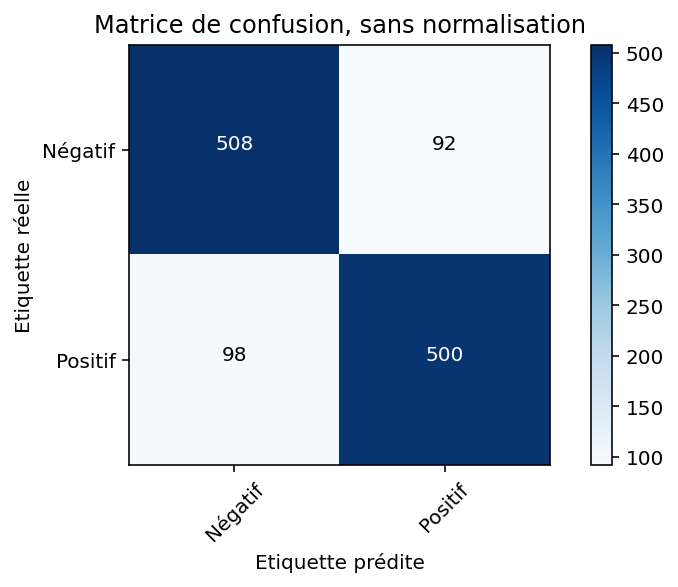

In [45]:
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_valid, Y_valid_pred_f), 
                      classes=id2label, 
                      title='Matrice de confusion, sans normalisation')
plt.show()


In [46]:
# on teste si une pondération TFIDF améliore les résultats
clf_t = LogisticRegression(
        #random_state=0, 
        solver='lbfgs',    # algo d'optimisation (ici minimisation de la perte cross-entropie)
        multi_class='ovr', # stratégie "one versus rest"
        penalty='l2', # hyperparamètre de régularisation
        C=1.0, # hyperparamètre de régularisation
        n_jobs=2
)

clf_t.fit(X_train_t, Y_train)

# --------- prediction sur le test---------------
Y_valid_pred_t = clf_t.predict(X_valid_t)
print("SCORE OF LOGISTIC REGRESSION ON VALID (tfidf): %.3f" % accuracy_score(Y_valid, Y_valid_pred_t))
    

# --------- prediction sur le train--------------
Y_train_pred_t = clf_t.predict(X_train_t)
print("SCORE OF LOGISTIC REGRESSION ON TRAIN (tfidf): %.3f" % accuracy_score(Y_train, Y_train_pred_t))

#@@ => on peut voir que le tfidf n'a pas un gros impact sur les résultats

SCORE OF LOGISTIC REGRESSION ON VALID (tfidf): 0.840
SCORE OF LOGISTIC REGRESSION ON TRAIN (tfidf): 1.000


## Un autre type de classifieur linéaire : les SVM

### TODO6: Appliquez l'apprentissage, la prédiction et l'évaluation, en utilisant cette fois un classifieur de type **SVM** (**support vector machine**), avec les hyperparamètres par défaut
- cf. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- Comparez **avec et sans utilisation de Tfidf** (CountVectorizer versus TfidfVectorizer).

**NB** : en apprentissage automatique, on distingue:
* les **paramètres**, qui sont des variables dont les valeurs sont fixées grâce au processus d'apprentissage. Celui-ci est en général un problème d'optimisation, résolu
  * soit de manière 
  * soit de manière approchée et itérative, auquel cas, en général, les paramètres sont initialisés (au hasard ou avec des valeurs pré-apprises sur d'autres tâches) et ajustés itérativement
* des **hyperparamètres**, qui sont des valeurs fixées en amont du processus d'apprentissage
  * chaque algo d'apprentissage va de paire avec un certain nombre d'hyperparamètres à choisir avant l'apprentissage
  * par exemple, pour un apprentissage de type régression logistique, on peut choisir d'inclure ou pas un terme régularisateur à la fonction de perte (cf. supra l'option penalty='l2' pour l'instance de LogisticRegression)
  * et en amont, les divers pré-traitements constituent des hyperparamètres
    * utilisation des formes fléchies, des lemmes ou des stems
    * pondération tf.idf ou pas
    * minusculisation ou pas
    * suppression ou pas des accents
    * si tf.idf, utilisation diverse des options max_df, min_df, max_features
    * etc...


SCORE OF SVM ON VALID : 0.774
SCORE OF SVM ON TRAIN : 0.870 

Matrice de confusion, sans normalisation
[[452 148]
 [123 475]]


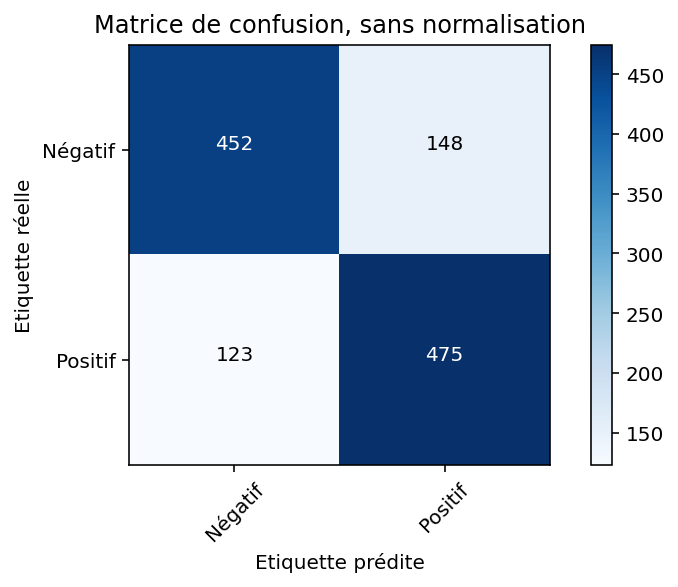

In [47]:
from sklearn import svm

# TODO
# apprentissage SVM


from sklearn.svm import SVC


#apprentissage pour countVectorizer 
classifier_svm = SVC()
classifier_svm.fit(X_train_f, Y_train)


#Prediction  
Y_valid_pred_f2 = classifier_svm.predict(X_valid_f)
Y_train_pred_f2 = classifier_svm.predict(X_train_f)



# évaluation sur corpus "valid" et sur corpus "train" (et affichage)
print("SCORE OF SVM ON VALID : %.3f" % accuracy_score(Y_valid, Y_valid_pred_f2))
print("SCORE OF SVM ON TRAIN : %.3f" % accuracy_score(Y_train, Y_train_pred_f2),"\n")



np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_valid, Y_valid_pred_f2), 
                      classes=id2label, 
                      title='Matrice de confusion, sans normalisation')
plt.show()


SCORE OF SVM ON VALID (tfidf): 0.825
SCORE OF SVM ON TRAIN (tfidf): 0.974 

Matrice de confusion, sans normalisation
[[493 107]
 [103 495]]


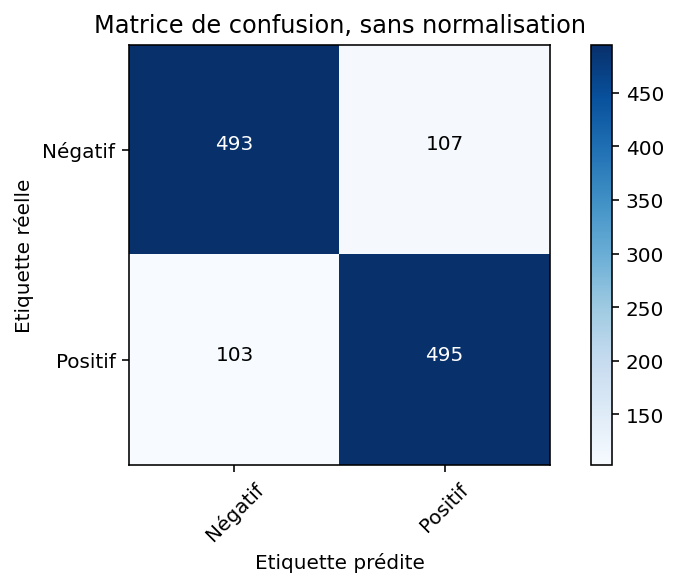

In [48]:
from sklearn import svm

# TODO

# apprentissage SVM tfidf
classifier_svm = SVC()
classifier_svm.fit(X_train_t, Y_train)


#Prediction
Y_valid_pred_t2 = classifier_svm.predict(X_valid_t)
Y_train_pred_t2 = classifier_svm.predict(X_train_t)


# évaluation sur corpus "valid" et sur corpus "train" (et affichage)

print("SCORE OF SVM ON VALID (tfidf): %.3f" % accuracy_score(Y_valid, Y_valid_pred_t2))

print("SCORE OF SVM ON TRAIN (tfidf): %.3f" % accuracy_score(Y_train, Y_train_pred_t2),"\n")


np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_valid, Y_valid_pred_t2), 
                      classes=id2label, 
                      title='Matrice de confusion, sans normalisation')
plt.show()



## Le réglage des hyperparamètres ("tuning hyperparameters")

Certains algorithmes vont avoir des performances très différentes selon les valeurs des hyperparamètres. Rechercher de bonnes valeurs d'hyperparamètres se dit **régler les hyperparamètres** (en anglais **tuning hyperparameters**).

Cela reste très expérimental, et fastidieux en particulier parce qu'on ne peut pas isoler les hyperparamètres les uns des autres: la meilleure valeur trouvée pour A, avec B=b, ne sera pas forcément la meilleure valeur pour A avec B=b'.

On en est simplement réduit à tester plusieurs combinaisons d'hyperparamètres, et choisir la meilleure sur ces tests. Plusieurs stratégies existent pour définir les combinaisons à tester:
* par tatonnement
  * éventuellement ok pour commencer à avoir une idée de l'ordre de grandeur des valeurs fonctionnant bien
  * mais il est recommandé d'avoir ensuite une approche plus systématique
* avec une **recherche en grille** (**grid search**): on teste de manière systématique les combinaisons de valeurs
  * par exemple on teste toutes les combinaisons avec A prenant les valeurs a, a'', a''' et B prenant les valeurs b, b' => 6 combinaisons.
  * mais le nb de combinaisons à tester peut devenir rapidement trop important
* ou encore avec une recherche aléatoire de combinaisons


### La validation croisée ("cross-validation")


**NB**: l'évaluation des performances pour chaque combinaison d'hyperparamètres doit être faite **sur des exemples non utilisés à l'apprentissage**. 
Une solution serait d'utiliser le corpus valid, mais cela biaiserait les résultats: la meilleure combinaison d'hyperparamètres obtenue serait celle valable pour le corpus valid. On veut garder celui-ci pour une évaluation finale.

C'est pourquoi on utilise plutôt la **validation croisée** (**cross-validation**) pour évaluer la performances de chaque combinaison d'hyperparamètes.

### BONUS TODO 7: explorez GridSearchCV et lancer une recherche en grille avec la grille d'hyperparamètres fournies infra.


In [49]:
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import StratifiedKFold

# définition des combinaisons d'hyperparamètres à tester
# comme l'existence de certains hyperparamètres dépend de la valeur d'autres hyperparamètre,
# ces combinaisons sont définies comme des dictionnaires
param_grid = [
    {'C': [0.001, 0.1, 1, 10, 100], 
     'kernel': ['linear']},
    {'C': [0.1, 1, 10, 100], 
     'gamma': ['scale','auto', 0.001], # gamma n'est pertinent que si kernel=rbf
     'kernel': ['rbf']},
    ]

# on utilise un vectorizer trouvé en faisant varier diverses options
vectorizer = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy,
                                            max_features = 10000,
                                            min_df = 2,
                                            max_df = 0.7)
X_train_f = vectorizer.fit_transform(df['train']['lemmas'])
X_valid_f = vectorizer.transform(df['valid']['lemmas'])



In [50]:
#TODO BONUS grid search

gr = GridSearchCV(estimator=SVC(),
             param_grid= param_grid,
             cv=2,verbose=3
            )

gr

GridSearchCV(cv=2, estimator=SVC(),
             param_grid=[{'C': [0.001, 0.1, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100],
                          'gamma': ['scale', 'auto', 0.001],
                          'kernel': ['rbf']}],
             verbose=3)

In [51]:
gr.fit(X_train_f, Y_train)

Fitting 2 folds for each of 17 candidates, totalling 34 fits
[CV 1/2] END ............C=0.001, kernel=linear;, score=0.500 total time=   4.1s
[CV 2/2] END ............C=0.001, kernel=linear;, score=0.574 total time=   3.9s
[CV 1/2] END ..............C=0.1, kernel=linear;, score=0.732 total time=   3.9s
[CV 2/2] END ..............C=0.1, kernel=linear;, score=0.696 total time=   3.7s
[CV 1/2] END ................C=1, kernel=linear;, score=0.777 total time=   3.1s
[CV 2/2] END ................C=1, kernel=linear;, score=0.794 total time=   2.9s
[CV 1/2] END ...............C=10, kernel=linear;, score=0.771 total time=   3.2s
[CV 2/2] END ...............C=10, kernel=linear;, score=0.774 total time=   3.0s
[CV 1/2] END ..............C=100, kernel=linear;, score=0.773 total time=   3.2s
[CV 2/2] END ..............C=100, kernel=linear;, score=0.774 total time=   3.1s
[CV 1/2] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.663 total time=   4.1s
[CV 2/2] END ....C=0.1, gamma=scale, kernel=rbf;

GridSearchCV(cv=2, estimator=SVC(),
             param_grid=[{'C': [0.001, 0.1, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100],
                          'gamma': ['scale', 'auto', 0.001],
                          'kernel': ['rbf']}],
             verbose=3)

In [52]:
print(gr.best_params_,"   ", gr.best_score_)

{'C': 1, 'kernel': 'linear'}     0.7855820133388912


# évaluation sur corpus "valid" et sur corpus "train" avec les paramètres (supposés meilleurs)  suggérés par gridsearchcv: 
 
SCORE OF SVM ON VALID : 0.846
SCORE OF SVM ON TRAIN : 0.957 

Matrice de confusion, sans normalisation
[[507  93]
 [ 91 507]]


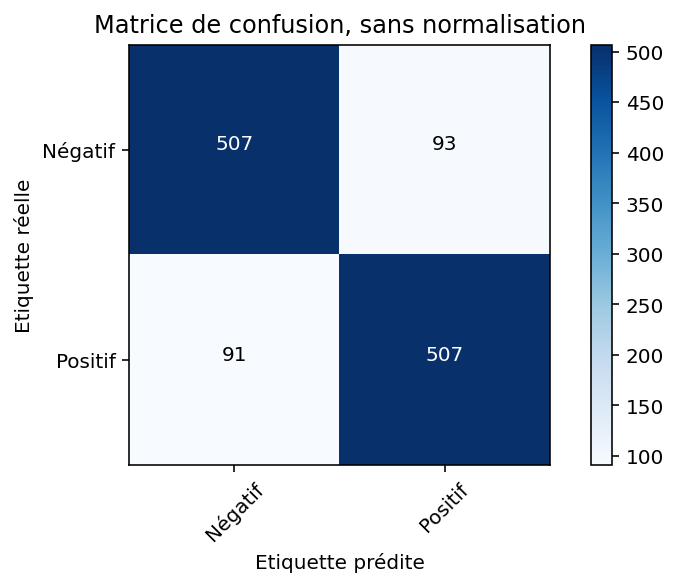

In [53]:
# apprentissage SVM tfidf
classifier_svm_b = SVC(C=1, kernel="linear")
classifier_svm_b.fit(X_train_f, Y_train)


#Prediction
Y_valid_pred_best = classifier_svm_b.predict(X_valid_f)
Y_train_pred_best = classifier_svm_b.predict(X_train_f)


print("# évaluation sur corpus \"valid\" et sur corpus \"train\" avec les paramètres (supposés meilleurs)  suggérés par gridsearchcv: \n ")
print("SCORE OF SVM ON VALID : %.3f" % accuracy_score(Y_valid, Y_valid_pred_best))

print("SCORE OF SVM ON TRAIN : %.3f" % accuracy_score(Y_train, Y_train_pred_best),"\n")


np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_valid, Y_valid_pred_best), 
                      classes=id2label, 
                      title='Matrice de confusion, sans normalisation')
plt.show()

